# This script demonstrates how to build a multi-modal variational autoencoder with vae_tools

In [1]:
import vae_tools # Always import first to define if keras or tf.kreas should be used
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
from vae_tools.mmvae import MmVae, ReconstructionLoss
vae_tools.sanity.check()
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Lambda, Layer
from keras.datasets import mnist
import numpy as np
from scipy.stats import norm
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
# resize the notebook if desired
#vae_tools.nb_tools.notebook_resize()

keras version: 2.1.6-tf
tensorflow version: 1.12.0
matplotlib uses:  module://ipykernel.pylab.backend_inline
Available GPUs True


In [2]:
# Get the MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

encoder_input_dim:  784
reconstruction_loss_metric:  ['MSE', 'BCE']
Store model to filename: tmp/myVAE.png and tmp/myVAE.svg
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 2)            258         dense_1[0][0]     

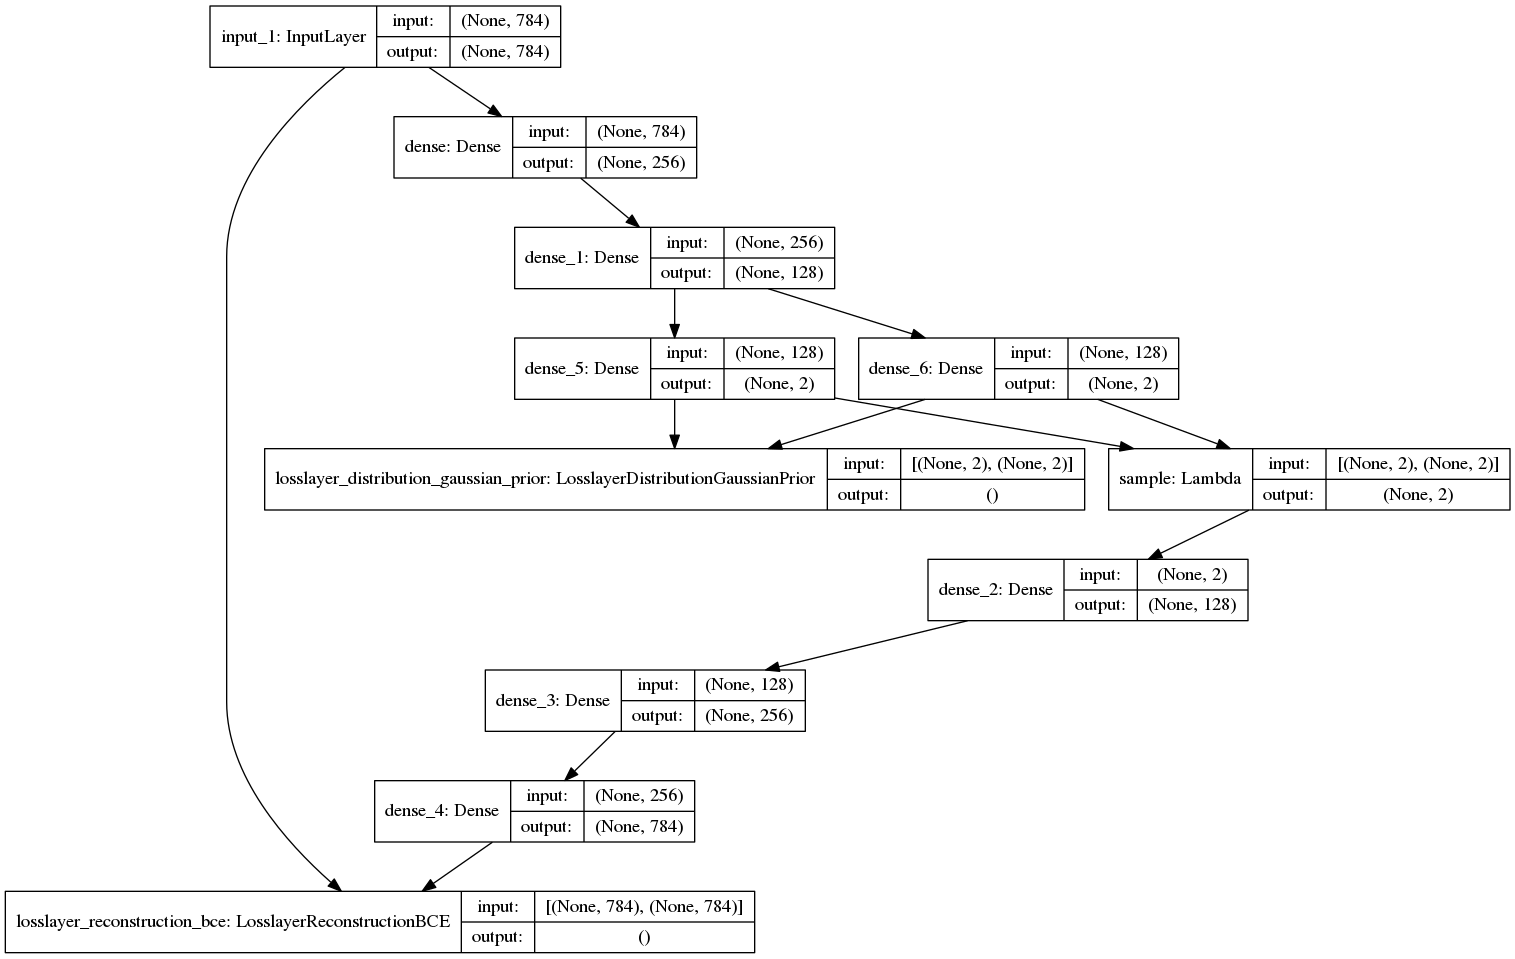

In [3]:
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
batch_size = 1024
original_dim = img_rows * img_cols * img_chns
intermediate_dim = 256
epochs = 50
z_dim = 2
beta = 1.

encoder = [[
    Input(shape=(original_dim,)),                       # Input layer
    Dense(intermediate_dim, activation='relu'),         # First encoder layer
    Dense(int(intermediate_dim/2), activation='relu')   # Second encoder layer
]]

decoder = [[
    Dense(int(intermediate_dim/2), activation='relu'),  # First decoder layer
    Dense(intermediate_dim, activation='relu'),         # Second decoder layer
    Dense(original_dim, activation='sigmoid')           # Output layer
]]

vae_obj = MmVae(z_dim, encoder, decoder, [original_dim], beta, reconstruction_loss_metrics = [ReconstructionLoss.BCE], name='MmVae')

vae = vae_obj.get_model()
vae.compile(optimizer='rmsprop', loss=None)
vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)

In [ ]:
# Store the losses, encodings, and decodings to tensorboard
# It is important to include the native Tensorboard callback as well besides vae_tools.callbacks.Tb*
log_dir = './Graph/mnist_wo_conv'

writer = tf.summary.FileWriter(log_dir) # Get a writer for our own callbacks
tb_cb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
tblosses_cb = vae_tools.callbacks.TbLosses(writer = writer, data = x_test, log_dir=log_dir)
tbembedding_cb = vae_tools.callbacks.TbEmbedding(writer = writer, data = x_test, encoder_model = vae_obj.get_encoder_mean([encoder[0][0]]), labels = y_test, log_dir=log_dir)
tbdecoding_cb = vae_tools.callbacks.TbDecoding2dGaussian(writer = writer, decoder_model = vae_obj.get_decoder(), log_dir=log_dir)
# Store the losses to a history object for plotting
losses_cb = vae_tools.callbacks.Losses(data = x_test)
# Train
vae.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None),
            verbose = 0,
            callbacks=[tb_cb, tblosses_cb, tbdecoding_cb, tbembedding_cb, losses_cb])

In [ ]:
# Show the losses
import matplotlib
import matplotlib.pyplot as plt
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=[10,10], dpi=96)
ax1.set_title("Losses")
ax1.plot(list(losses_cb.history.values())[0])
ax1.set_ylabel([list(losses_cb.history.keys())[0]])
ax2.plot(list(losses_cb.history.values())[1])
ax2.set_ylabel([list(losses_cb.history.keys())[1]])
ax3.plot(np.array(list(losses_cb.history.values())[0]) + np.array(list(losses_cb.history.values())[1]))
ax3.set_ylabel("ELBO")
plt.show()

In [ ]:
# build a digit generator that can sample from the learned distribution
generator = vae_obj.get_decoder()
from scipy.stats import norm
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-1-i) * digit_size: ((n-1-i) + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [ ]:
# build a model to project inputs on the latent space
encoder_input = [encoder[0][0]]
encoder_model = vae_obj.get_encoder_mean(encoder_input)
import io
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder_model.predict(x_test, batch_size=batch_size)
f = plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
plt.colorbar()
plt.axis("equal")
plt.show()